In [1]:
from lusidtools.jupyter_tools import toggle_code

"""Loading and calculating returns

Demonstration of how to load and calculate returns in LUSID.

Attributes
----------
Returns
"""

toggle_code("Toggle Docstring")

# Loading and calculating returns in LUSID

This notebook shows how you can load and calculate returns in LUSID. In the cells below, we load a CSV file of daily returns over a 5 year period (approximately). We then use LUSID to calculate various return metrics:

* Daily
* Since inception
* Week-to-date (WTD), Month-to-date (MTD), Quarter-to-date (QTD), Year-to-date (YTD)
* 1 month (1M), 3 months (3M), 1 Year (1Y)
* Since a specific date
* Annualised since incorporation
* 5 year annualised


# Setup LUSID

In [2]:
# Import general purpose packages
import os
import json
import pandas as pd
import numpy as np
import datetime
import pytz
import warnings

warnings.filterwarnings("ignore", module="matplotlib*")

import matplotlib.pyplot as plt

from datetime import datetime, timedelta

# Import lusid specific packages
import lusid
import lusid.models as models

from lusid.utilities import ApiClientFactory
from lusidjam.refreshing_token import RefreshingToken

# Set display configuration
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.5f" % x)
pd.set_option("display.max_rows", 3500)
pd.set_option("max_colwidth", 20)

# Use line magic function to enable matplotlib to work interactively with iPython
%matplotlib inline

# Set style to fivethirtyeight to create clean and clear looking graphs
plt.style.use("fivethirtyeight")

# Define a dictionary containing default plotting configurations
params = {
    "legend.fontsize": "small",
    "figure.figsize": (12, 4.5),
    "axes.labelsize": "small",
    "axes.titlesize": "medium",
    "xtick.labelsize": "small",
    "ytick.labelsize": "small",
}

plt.rcParams.update(params)

# Authenticate our user and create our API client
secrets_path = os.getenv("FBN_SECRETS_PATH")

# Initiate an API Factory which is the client side object for interacting with LUSID APIs
api_factory = lusid.utilities.ApiClientFactory(
    token=RefreshingToken(),
    api_secrets_filename=secrets_path,
    app_name="LusidJupyterNotebook",
)

api_status = pd.DataFrame(
    api_factory.build(lusid.api.ApplicationMetadataApi).get_lusid_versions().to_dict()
)

display(api_status)

,api_version,build_version,excel_version,links
0,v0,0.6.10373.0,0.5.3090,{'relation': 'Re...


# Setup defaults

In [3]:
# Define a scope to hold data

scope = "returns"
portfolio_code = "UK_EQUITY"

# Define the APIs we use

transaction_portfolios_api = api_factory.build(lusid.api.TransactionPortfoliosApi)
portfolios_api = api_factory.build(lusid.api.PortfoliosApi)

# Define dates
start_date = datetime(year=2020, month=1, day=2, tzinfo=pytz.UTC).isoformat
number_of_days = 366

# Create a portfolio

In [4]:
portfolios = [portfolio_code]

for port in portfolios:

    try:

        response = transaction_portfolios_api.create_portfolio(
            scope=scope,
            create_transaction_portfolio_request=models.CreateTransactionPortfolioRequest(
                display_name=port, code=port, created="2013-12-30", base_currency="GBP"
            ),
        )
    except lusid.ApiException as e:
        print(json.loads(e.body)["title"])

Could not create a portfolio with id 'UK_EQUITY' because it already exists in scope 'returns'.


# Upload a DataFrame of returns from CSV file to LUSID

In [5]:
returns_df = pd.read_csv("data/performance_data.csv", dtype={"daily_returns": np.int64})
returns_df["date"] = pd.to_datetime(returns_df["date"], format="%d/%m/%Y")
returns_df = returns_df.rename(
    columns={"mv": "market_value", "returns": "daily_returns"}
)

returns_df.head()

,date,market_value,daily_returns
0,2013-12-31,1000000.00000,0.00000
1,2014-01-01,993206.38000,-0.00679
2,2014-01-02,992628.45000,-0.00058
3,2014-01-03,996394.98000,0.00379
4,2014-01-04,1002500.97000,0.00613


> <b> NOTE: We have truncated the upsert to 10 rows. Remove the cell below if you want to load all 2500+ rows of daily returns.</b>

In [6]:
returns_df = returns_df[:10]

In [7]:
time_series_of_returns = [
    models.PerformanceReturn(
        effective_at=row["date"].isoformat()[:10],
        rate_of_return=row["daily_returns"],
        closing_market_value=row["market_value"],
        period="Daily",
    )
    for _, row in returns_df.iterrows()
]

return_code = "daily_return"

upsert_returns = portfolios_api.upsert_portfolio_returns(
    scope=scope,
    code=portfolio_code,
    return_code=return_code,
    return_scope=scope,
    performance_return=time_series_of_returns,
)

# Retrieve returns from LUSID

In [8]:
from_effective_at = datetime(year=2013, month=12, day=31, tzinfo=pytz.utc).isoformat()
to_effective_at = datetime(year=2020, month=5, day=3, tzinfo=pytz.utc).isoformat()

returns = portfolios_api.get_portfolio_aggregate_returns(
    scope=scope,
    code=portfolio_code,
    return_code=return_code,
    return_scope=scope,
    from_effective_at=from_effective_at,
    to_effective_at=to_effective_at,
    period="Daily",
    output_frequency="Daily",
    metrics=[
        "1D",
        "INC",
        "WTD",
        "MTD",
        "QTD",
        "YTD",
        "1M-ROLLING",
        "3M-ROLLING",
        "1Y-ROLLING",
        "SINCE(2014-03-19)",
        "ANNUALISED(INC)",
        "ANNUALISED(5Y-ROLLING)",
    ],
)

In [9]:
data = returns.values

summary_df = pd.DataFrame(
    columns=[
        "date",
        "opening_mv",
        "closing_mv",
        "day",
        "inception",
        "mtd",
        "ytd",
        "qtd",
        "wtd",
        "1m-rolling",
        "3m-rolling",
        "1y-rolling",
        "since_20140319",
        "annualised_inc",
        "annualised_5y-rolling",
    ]
)

for item in data:

    row = {}
    row["date"] = item.effective_at.strftime(format="%Y-%m-%d")
    row["opening_mv"] = item.opening_market_value
    row["closing_mv"] = item.opening_market_value
    row["day"] = item.metrics_value.get("1D")
    row["inception"] = item.metrics_value.get("INC")
    row["mtd"] = item.metrics_value.get("MTD")
    row["ytd"] = item.metrics_value.get("YTD")
    row["qtd"] = item.metrics_value.get("QTD")
    row["wtd"] = item.metrics_value.get("WTD")
    row["1m"] = item.metrics_value.get("1M-ROLLING")
    row["3m"] = item.metrics_value.get("3M-ROLLING")
    row["1y"] = item.metrics_value.get("1Y-ROLLING")
    row["since_20140319"] = item.metrics_value.get("SINCE(2014-03-19)")
    row["annualised_inc"] = item.metrics_value.get("ANNUALISED(INC)")
    row["annualised_5y"] = item.metrics_value.get("ANNUALISED(5Y-ROLLING)")

    summary_df = summary_df.append(row, ignore_index=True)
    
summary_df.tail(10)

,date,opening_mv,closing_mv,day,inception,mtd,ytd,qtd,wtd,1m-rolling,3m-rolling,1y-rolling,since_20140319,annualised_inc,annualised_5y-rolling,1m,1y,3m,annualised_5y
0,2013-12-31,1000000.00000,1000000.00000,0.00000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,None,None
1,2014-01-01,1000000.00000,1000000.00000,-0.00679,-0.00679,-0.00679,-0.00679,-0.00679,NaN,NaN,NaN,NaN,None,None,NaN,None,None,None,None
2,2014-01-02,993206.38000,993206.38000,-0.00058,-0.00737,-0.00737,-0.00737,-0.00737,NaN,NaN,NaN,NaN,None,None,NaN,None,None,None,None
3,2014-01-03,992628.45000,992628.45000,0.00379,-0.00361,-0.00361,-0.00361,-0.00361,NaN,NaN,NaN,NaN,None,None,NaN,None,None,None,None
4,2014-01-04,996394.98000,996394.98000,0.00613,0.00250,0.00250,0.00250,0.00250,NaN,NaN,NaN,NaN,None,None,NaN,None,None,None,None
5,2014-01-05,1002500.97000,1002500.97000,0.01061,0.01314,0.01314,0.01314,0.01314,NaN,NaN,NaN,NaN,None,None,NaN,None,None,None,None
6,2014-01-06,1013136.84000,1013136.84000,0.01366,0.02697,0.02697,0.02697,0.02697,0.01366,NaN,NaN,NaN,None,None,NaN,None,None,None,None
7,2014-01-07,1026973.90000,1026973.90000,0.00756,0.03474,0.03474,0.03474,0.03474,0.02132,NaN,NaN,NaN,None,None,NaN,None,None,None,None
8,2014-01-08,1034738.03000,1034738.03000,0.00615,0.04111,0.04111,0.04111,0.04111,0.02761,NaN,NaN,NaN,None,None,NaN,None,None,None,None
9,2014-01-09,1041105.56000,1041105.56000,0.00096,0.04210,0.04210,0.04210,0.04210,0.02859,NaN,NaN,NaN,None,None,NaN,None,None,None,None


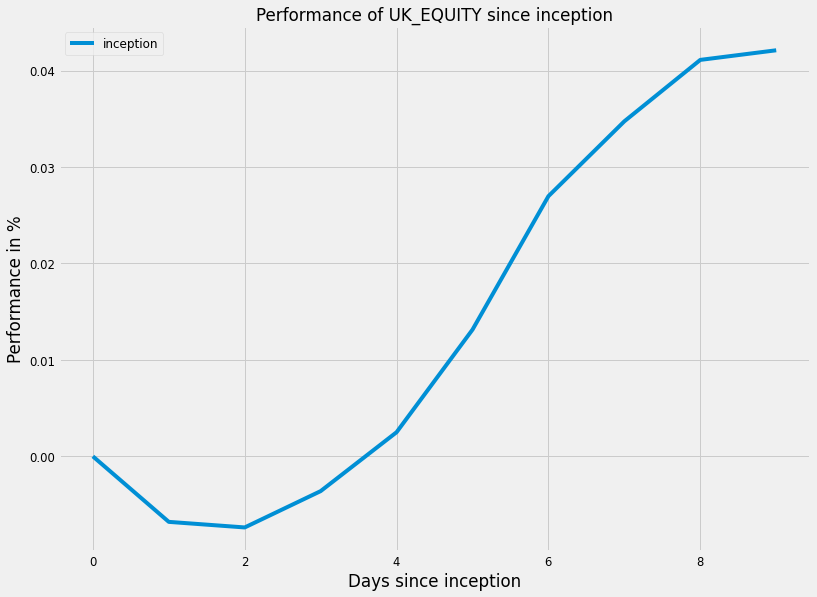

In [10]:
def time_series_performance():
    ts_performance = summary_df.plot(y=["inception"], figsize=(12, 9))
    ts_performance.set_title(
        f"Performance of {portfolio_code} since inception",
        fontsize="large",
    )
    ts_performance.set_ylabel("Performance in %", fontsize="large")
    ts_performance.set_xlabel("Days since inception", fontsize="large")
    ts_performance.legend(prop={"size": 12})
    
time_series_performance()

# Returns Dashboard

To view the returns loaded above, navigate to the following link:

In [ ]:
import os
api_url = os.getenv("FBN_LUSID_API_URL")
url = f"{api_url[:-3]}app/dashboard/returns?dateFrom=2013-12-31T00:00:00.000Z&dateTo=2022-11-29T23:59:59.999Z&frequency=Daily&compositeMethod=Asset&period=Daily&scope=returns&code=UK_EQUITY&entityType=Portfolio&returnsScope=returns&returnsCode=daily_return"
           
print(url)    